### VaR Comparison

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
import matplotlib.pyplot as plt

import seaborn as sns


In [59]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching stock data

In [2]:
stock_df = pd.read_csv('data/stock_data.csv')

In [3]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [4]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [5]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)

        if stock_data.empty:
            raise ValueError("No data found for the selected date range and tickers.")


        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [6]:

class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt


##### Fetching test portofolios

In [7]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [8]:
tp = test_portfolios[1]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

C:\Users\mario\AppData\Local\Temp\ipykernel_14260\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])


In [9]:
stock_data.head()

Price            Close                                       High              \
Ticker             AXP         DIS   NTDOY       PTON         AXP         DIS   
Date                                                                            
2021-10-14  167.531876  174.410004  11.394  85.849998  168.381706  176.020004   
2021-10-15  171.732132  176.460007  11.258  85.110001  173.646677  178.889999   
2021-10-18  172.718719  171.139999  11.240  87.650002  173.490389  173.339996   
2021-10-19  173.197342  171.179993  11.210  88.190002  173.871340  171.580002   
2021-10-20  175.434235  170.550003  10.946  90.650002  175.600290  171.020004   

Price                                 Low                                 \
Ticker       NTDOY       PTON         AXP         DIS   NTDOY       PTON   
Date                                                                       
2021-10-14  11.498  88.199997  165.871310  174.000000  11.324  85.309998   
2021-10-15  11.310  86.599998  169.133826  174.100006  11.240  84.470001   
2021-10-18  11.274  88.900002  170.286469  169.800003  11.188  83.580002   
2021-10-19  11.308  88.300003  172.171693  170.179993  11.152  85.870003   
2021-10-20  11.000  93.750000  172.122865  169.880005  10.930  89.779999   

Price             Open                                    Volume              \
Ticker             AXP         DIS   NTDOY       PTON        AXP         DIS   
Date                                                                           
2021-10-14  167.033710  174.070007  11.498  87.970001  3061900.0   7450200.0   
2021-10-15  169.739456  175.690002  11.264  86.099998  3043900.0  13943900.0   
2021-10-18  171.507476  172.360001  11.214  85.110001  2623300.0  20494800.0   
2021-10-19  173.607598  171.440002  11.308  87.550003  1400100.0   9669500.0   
2021-10-20  172.845692  170.970001  10.998  91.410004  2398500.0   9737600.0   

Price                             
Ticker          NTDOY       PTON  
Date                              
2021-10-14  1112500.0  3332800.0  
2021-10-15  2115000.0  4174700.0  
2021-10-18  3041500.0  6496000.0  
2021-10-19  2145500.0  4020600.0  
2021-10-20  3151000.0  9689600.0

In [10]:

yf_data = yf.download(stocks, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


#### Comparing the VaR methods

In [11]:
# Get returns for each portofolio
returns = []
portofolios = []

for test_portfolio in test_portfolios:

    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)
    

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


C:\Users\mario\AppData\Local\Temp\ipykernel_14260\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])
C:\Users\mario\AppData\Local\Temp\ipykernel_14260\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])
C:\Users\mario\AppData\Local\Temp\ipykernel_14260\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [12]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

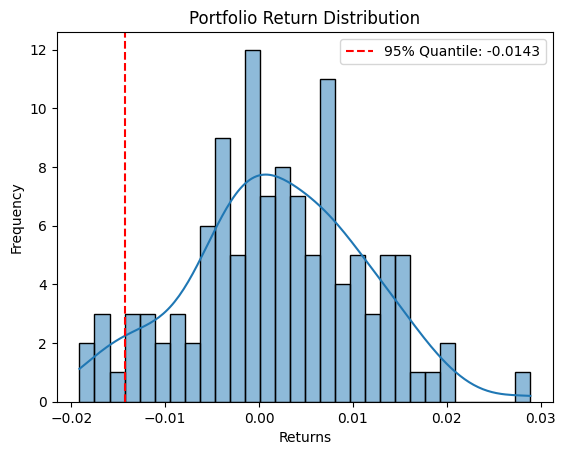

In [13]:
show_portfolio_distribution(returns[2]['portofolio'])

In [14]:
def compare_portfolio_distributions(forecast_returns, historic_returns, label1="Returns to Forecast", label2="Past historical Returns", quantile=0.05):
    plt.figure(figsize=(10, 6))
    
    # Plot both distributions
    sns.histplot(forecast_returns, bins=30, kde=True, color='blue', label=label1, stat="density", alpha=0.6)
    sns.histplot(historic_returns, bins=30, kde=True, color='orange', label=label2, stat="density", alpha=0.6)

    # Calculate quantiles
    q1 = forecast_returns.quantile(quantile)
    q2 = historic_returns.quantile(quantile)

    # Add vertical lines at quantiles
    plt.axvline(q1, color='blue', linestyle='dashed', label=f'{label1} {int(quantile*100)}% Quantile: {q1:.4f}')
    plt.axvline(q2, color='orange', linestyle='dashed', label=f'{label2} {int(quantile*100)}% Quantile: {q2:.4f}')
    
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Comparison of Portfolio Return Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

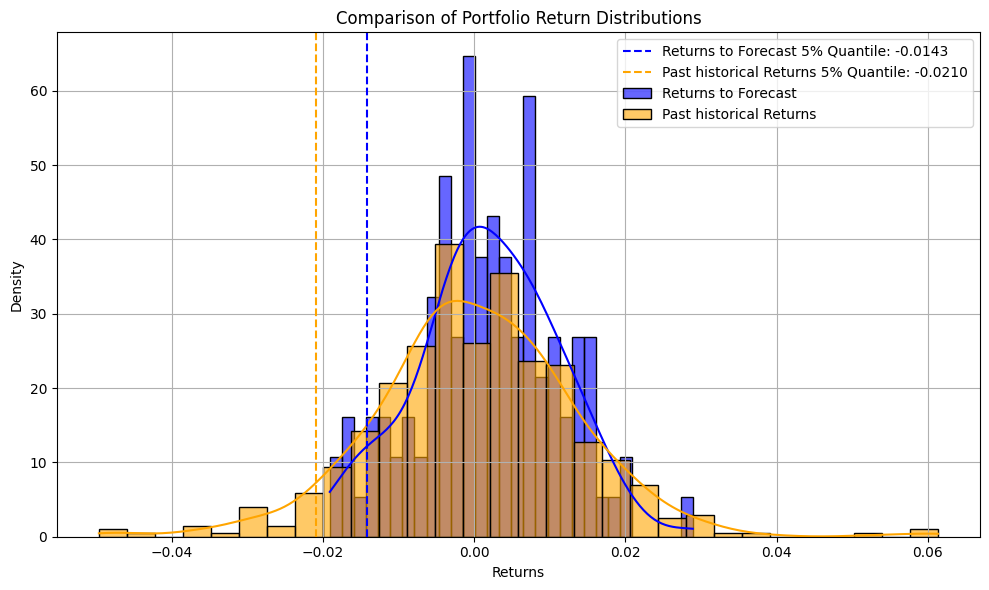

In [15]:
index = 2

compare_portfolio_distributions(returns[2]['portofolio'],portofolios[index].returns['portofolio'])

In [16]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = VaR(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [17]:


def show_portfolio_distribution_with_vars(returns, var_dict, time_horizon=1, quantile=0.05, ):
    # Plot the distribution with histogram and KDE
    returns = returns * np.sqrt(time_horizon)  # Scale returns for the time horizon
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



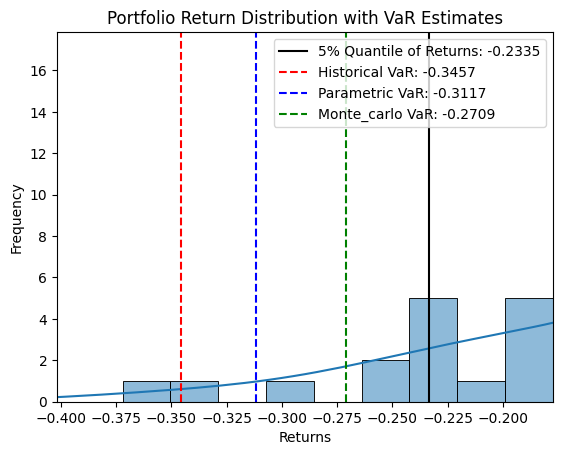

In [18]:
min_index = 4
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'][:], values_at_risk[min_index], time_horizon=portofolios[min_index].Time, quantile=0.05)

##### RMSE

For our chosen way of comparing the models, we will pick the root square mean deviation (RMSE).

In [19]:
def rmse_of_quantiles(VaR, actual_losses):
    return np.sqrt(np.mean((VaR - actual_losses) ** 2))

In [ ]:
rmses = []

for i in range(len(values_at_risk)):
    actual_losses = returns[i]['portofolio'].quantile(0.95)
    historical_var = values_at_risk[i]['historical']
    parametric_var = values_at_risk[i]['parametric']
    monte_carlo_var = values_at_risk[i]['monte_carlo']

    rmses.append(
        {
            "historical": rmse_of_quantiles(historical_var, actual_losses),
            "parametric": rmse_of_quantiles(parametric_var, actual_losses),
            "monte_carlo": rmse_of_quantiles(monte_carlo_var, actual_losses),
        }
    )

In [21]:
returns[0]['portofolio'].quantile(0.05)

np.float64(-0.015285961500221733)

In [22]:
values_at_risk[0]['historical']

np.float64(-0.39935388850961073)

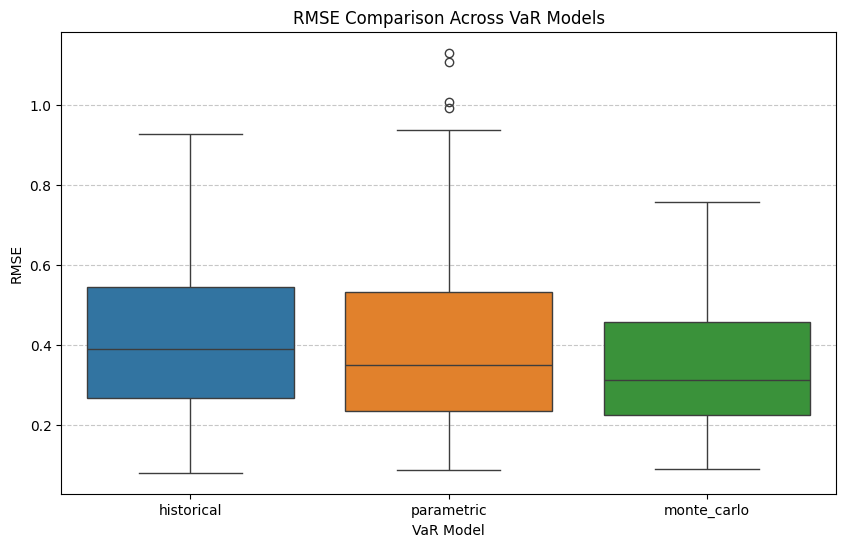

In [23]:
rmse_df = pd.DataFrame(rmses)

# Plot the RMSE values
plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df)

plt.title("RMSE Comparison Across VaR Models")
plt.ylabel("RMSE")
plt.xlabel("VaR Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [24]:
len(rmse_df)

100

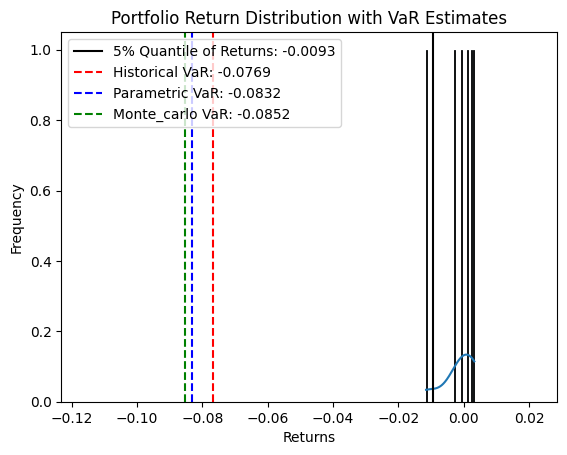

In [25]:
min_index = rmse_df['historical'].idxmin()
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'], values_at_risk[min_index], quantile=0.05)

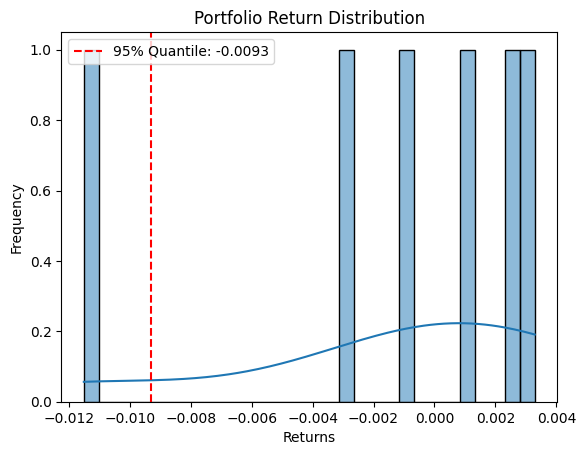

In [26]:
show_portfolio_distribution(returns[min_index]['portofolio'], quantile=0.05)

In [27]:
test_portfolios[min_index]

{'stocks_list': ['HLT',
  'NVDA',
  'CRM',
  'SBUX',
  'FL',
  'PMMAF',
  'AEO',
  'PG',
  'MCD'],
 'stocks_weights': [0.06700000000000012,
  0.09,
  0.174,
  0.12,
  0.102,
  0.163,
  0.088,
  0.097,
  0.099],
 'initial_investment': 27951.21,
 'time': 8,
 'start_date': datetime.datetime(2023, 12, 4, 0, 0)}

In [28]:
rmse_df.describe()

,historical,parametric,monte_carlo
count,100.000000,100.000000,100.000000
mean,0.407050,0.408581,0.346040
std,0.192137,0.240600,0.164689
min,0.079980,0.086243,0.088331
25%,0.265831,0.234322,0.223910
50%,0.388424,0.349379,0.311823
75%,0.545428,0.530753,0.457762
max,0.926748,1.130829,0.756456


##### Backtesting

In [31]:
def calculate_rolling_returns(returns, window=5):
    rolling_returns = returns.rolling(window=window).sum()  
    return rolling_returns.dropna()


In [32]:
import copy

In [113]:
def backtest_all_var_methods(portofolio: PortofolioData, confidence_level=0.95):
    start_date = pd.to_datetime("2023-07-01")
    end_date = pd.to_datetime("2024-12-01")

    backtesting_portofolio = PortofolioData(portofolio.stocks, portofolio.weights, portofolio.Time, portofolio.initial_investment)

    returns, _, _ = backtesting_portofolio.get_data(start_date, end_date, False)
    returns = returns['portofolio']
    window = portofolio.Time  

    results = {
        'historical': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
        'parametric': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
        'monte_carlo': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []}
    }

    for i in range(len(returns) - window + 1):
        window_returns = returns.iloc[i:i+window]
        # Create a deep copy of the portfolio and update its returns and Time horizon
        sub_portfolio = PortofolioData(portofolio.stocks, portofolio.weights, window, portofolio.initial_investment, forecast_start_date=window_returns.index[-1])


        # Instantiate the VaR object with this sub-portfolio.
        var_obj = VaR(sub_portfolio, confidence_level)

        # Calculate VaR using each of the three methods:
        hist_dict  = var_obj.calculate_historical_var()
        param_dict = var_obj.calculate_parametric_var()
        mc_dict    = var_obj.calculate_monte_carlo_var()

        # Save each method's predicted VaR (relative loss)
        results['historical']['predictions'].append(hist_dict["relative"])
        results['parametric']['predictions'].append(param_dict["relative"])
        results['monte_carlo']['predictions'].append(mc_dict["relative"])
  
        # Compute the actual cumulative loss over the window.
        # (For small returns, summing daily returns is an approximation.)
        actual_loss = window_returns.sum()

        # print(f"Actual Loss: {actual_loss}")
        # print(f'VaR Historical: {hist_dict["relative"]}')
        # print(f'VaR Parametric: {param_dict["relative"]}')
        # print(f'VaR Monte Carlo: {mc_dict["relative"]}')
        # print('---------------------')

        results['historical']['actuals'].append(actual_loss)
        results['parametric']['actuals'].append(actual_loss)
        results['monte_carlo']['actuals'].append(actual_loss)
        
        # Mark a violation if actual loss exceeds predicted VaR.
        results['historical']['violations'].append(1 if actual_loss > hist_dict["relative"] else 0)
        results['parametric']['violations'].append(1 if actual_loss > param_dict["relative"] else 0)
        results['monte_carlo']['violations'].append(1 if actual_loss > mc_dict["relative"] else 0)
     
        # Record the ending index of the window (could be a date)
        idx = window_returns.index[-1]
        results['historical']['indices'].append(idx)
        results['parametric']['indices'].append(idx)
        results['monte_carlo']['indices'].append(idx)

    # Calculate overall violation percentages for each method.
    out = {}
    for method in results:
        viols = results[method]['violations']
        violation_pct = np.mean(viols) * 100
        out[method] = {
            'violation_pct': violation_pct,
            'violations': results[method]['violations'],
            'indices': results[method]['indices'],
            'predictions': results[method]['predictions'],
            'actuals': results[method]['actuals']
        }
    return out


In [114]:
backtest_results = backtest_all_var_methods(portofolios[0], confidence_level=0.95)

In [115]:
for method, res in backtest_results.items():
    print(f"{method.capitalize()} VaR: {res['violation_pct']:.2f}%")

Historical VaR: 0.00%
Parametric VaR: 18.92%
Monte_carlo VaR: 21.62%


In [116]:
results_dict = {
    'Historical': [],
    'Parametric': [],
    'Monte Carlo': []
}
cnt = 0
for portofolio in portofolios:
    cnt+=1
    print(f'{cnt} done')
    backtest_results = backtest_all_var_methods(portofolio, confidence_level=0.95)
    # Each backtest_results is a dictionary with keys 'historical', 'parametric', 'monte_carlo'
    results_dict['Historical'].append(backtest_results['historical']['violation_pct'])
    results_dict['Parametric'].append(backtest_results['parametric']['violation_pct'])
    results_dict['Monte Carlo'].append(backtest_results['monte_carlo']['violation_pct'])

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done


In [117]:
df_results = pd.DataFrame(results_dict)
df_results.describe()

,Historical,Parametric,Monte Carlo
count,98.000000,98.000000,98.000000
mean,11.534169,34.372936,35.224138
std,20.166106,39.002733,38.395669
min,0.000000,0.000000,0.000000
25%,0.000000,1.798884,2.915827
50%,2.546445,12.925566,15.174986
75%,10.828300,70.886396,69.648318
max,100.000000,100.000000,100.000000


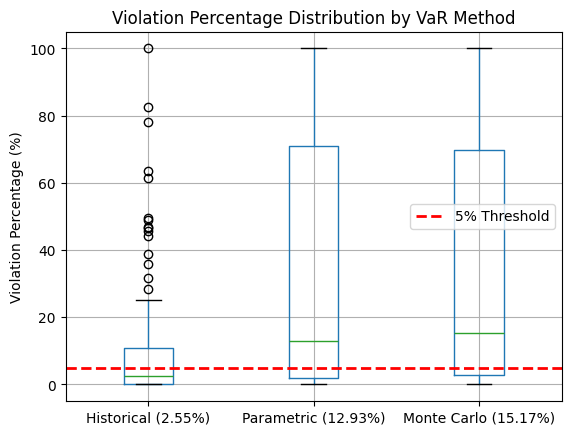

In [118]:
medians = df_results.median()

# Rename x-axis labels to include median values
new_labels = [f"{col} ({medians[col]:.2f}%)" for col in df_results.columns]

# Create the boxplot
ax = df_results.boxplot()
plt.title("Violation Percentage Distribution by VaR Method")
plt.ylabel("Violation Percentage (%)")

# Draw a horizontal line at y = 5
plt.axhline(y=5, color='red', linestyle='--', linewidth=2, label="5% Threshold")

# Set the updated x-tick labels with medians
ax.set_xticklabels(new_labels)

plt.legend()
plt.show()

### Custom VaR Model